Start by importing the necessary Python packages, including flowgatenist:

In [1]:
import glob #filenames and pathnames utility
import os   #operating sytem utility

import flowgatenist as flow
import flowgatenist.batch_process as batch_p

import matplotlib.pyplot as plt
from matplotlib import colors
#from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
#import pandas as pd
#from scipy import special
#from scipy import misc

#import pystan
import pickle

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

%matplotlib inline

<br>
Indicate the directories where this notebook and the data are located:

In [2]:
notebook_directory = os.getcwd()
notebook_directory

'C:\\Users\\djross\\Documents\\Python Scripts\\flowgatenist\\example data\\Jupyter notebooks'

In [3]:
data_directory = notebook_directory[:notebook_directory.rfind("\\")]
os.chdir(data_directory)
data_directory

'C:\\Users\\djross\\Documents\\Python Scripts\\flowgatenist\\example data'

<br>
Then check bead data file to make sure it has enough events (more than about 10,000 should be ok).

In [4]:
bead_file = glob.glob('*bead*.fcs_pkl')[0]
bead_file

'Beads_H12.fcs_pkl'

In [5]:
bead_data = pickle.load(open(bead_file, 'rb'))
bead_data.flow_frame.shape

(92576, 40)

<br>
Then call the fit_bead_data() function.<br>
That function uses the data from the bead sample to detirmine the calibration from the flow cytometry signal to molecules of equivalent fluoreophore (MEF).<br>
By default, the function automatically selects a bead data file, though it can also be manually specified with the optional bead_file argument.<br>
The num_bead_populations parameter needs to be set equal to the number of beads that are on-scale for both the BL1-A and YL1-A channels. In the example here, num_bead_populations is 7.<br>
By default, the parameters bead_init, singlet_init, and bead_population_init are set to large values to reduce the probability of a bad fit resulting from the random GMM initializations. This casues the method to run more slowly however. So, for testing, and/or if a person will be able to verify that the GMM fits give satisfoactory results, those parameters can be reduced to smaller values.

Main bead cluster mean: [253461.8228167  489257.39769903]


(array([-5.10417486e-10,  7.25805792e+02,  3.91980991e+03,  9.60655807e+03,
         2.73874310e+04,  7.93835054e+04,  8.37153317e+04]),
 array([-1.07885236e-08,  5.99559772e+02,  3.10577733e+03,  7.51401051e+03,
         2.19344161e+04,  6.56405977e+04,  6.76075037e+04]),
 array([     0.        ,   5038.9887566 ,  27213.72344258,  66694.61538462,
        190140.33549083, 551128.96034436, 581203.15408475]),
 array([     0.        ,   1427.12302256,   7392.63463025,  17885.48512821,
         52210.1574973 , 156243.31796176, 160925.11447374]),
 array([1.00000000e-06, 1.65229626e+07, 6.47116602e+06, 1.90557169e+07,
        7.95076862e+07, 1.97561102e+08, 2.32462448e+08]),
 array([1.00000000e-06, 1.09088599e+06, 3.15818672e+05, 7.69548670e+05,
        2.41665926e+06, 6.08120198e+06, 6.36503153e+06]),
 array([[6.47116602e+06, 3.15818672e+05],
        [2.32462448e+08, 6.36503153e+06],
        [7.95076862e+07, 2.41665926e+06],
        [1.90557169e+07, 7.69548670e+05],
        [1.65229626e+07,

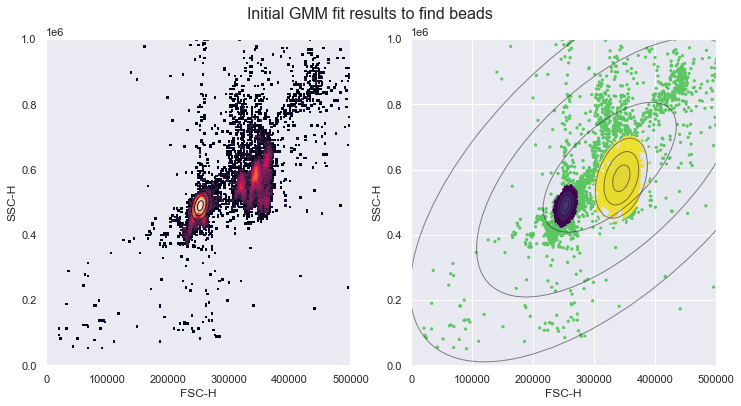

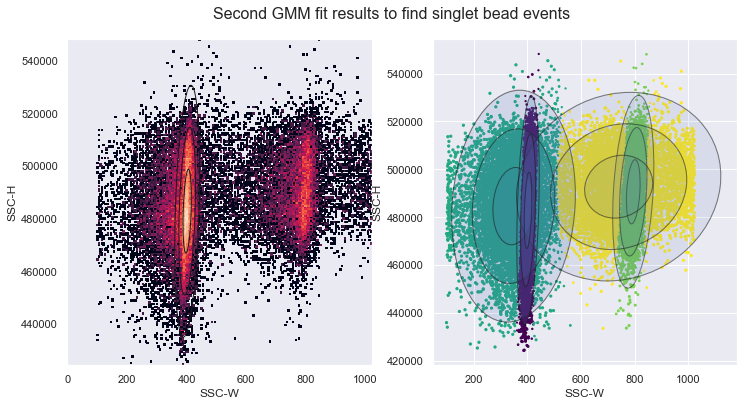

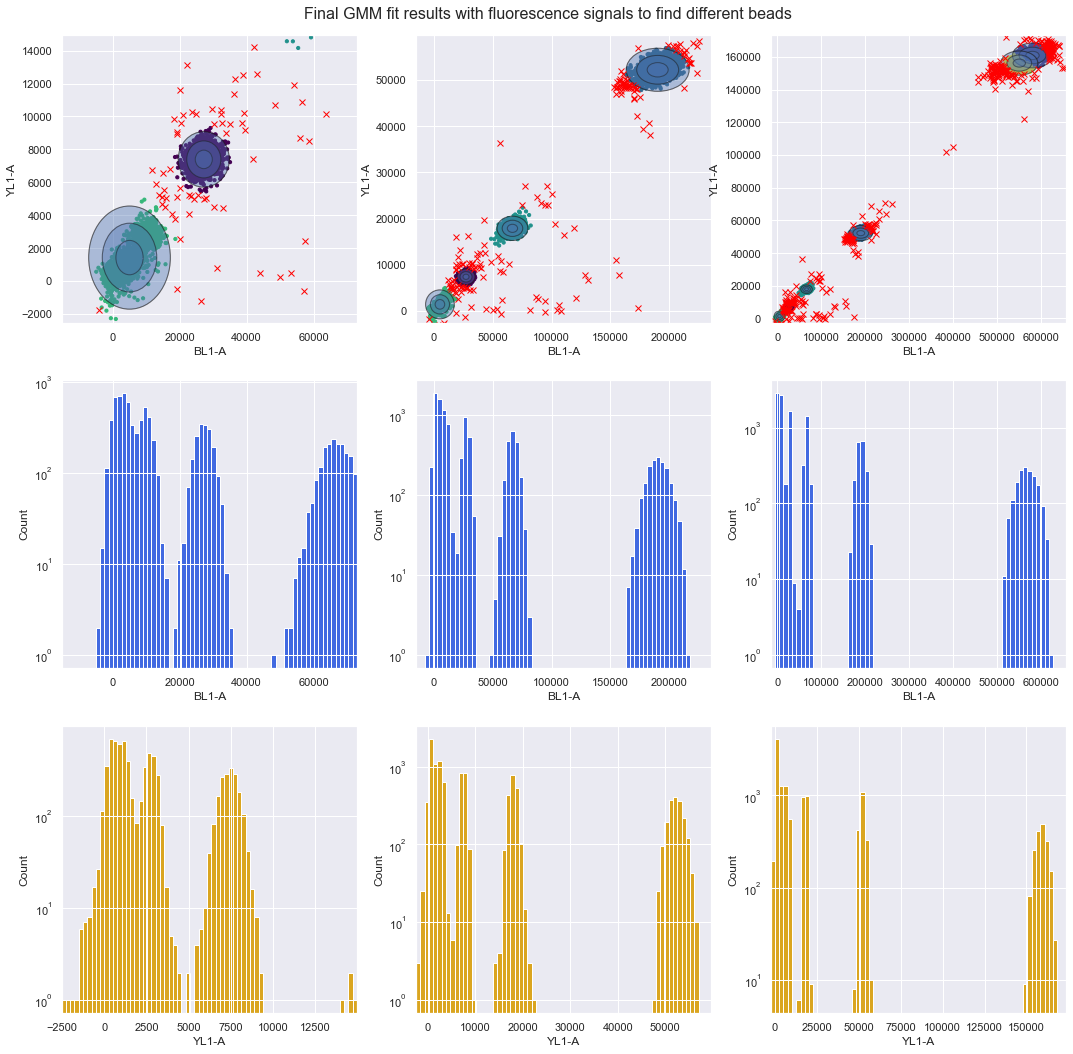

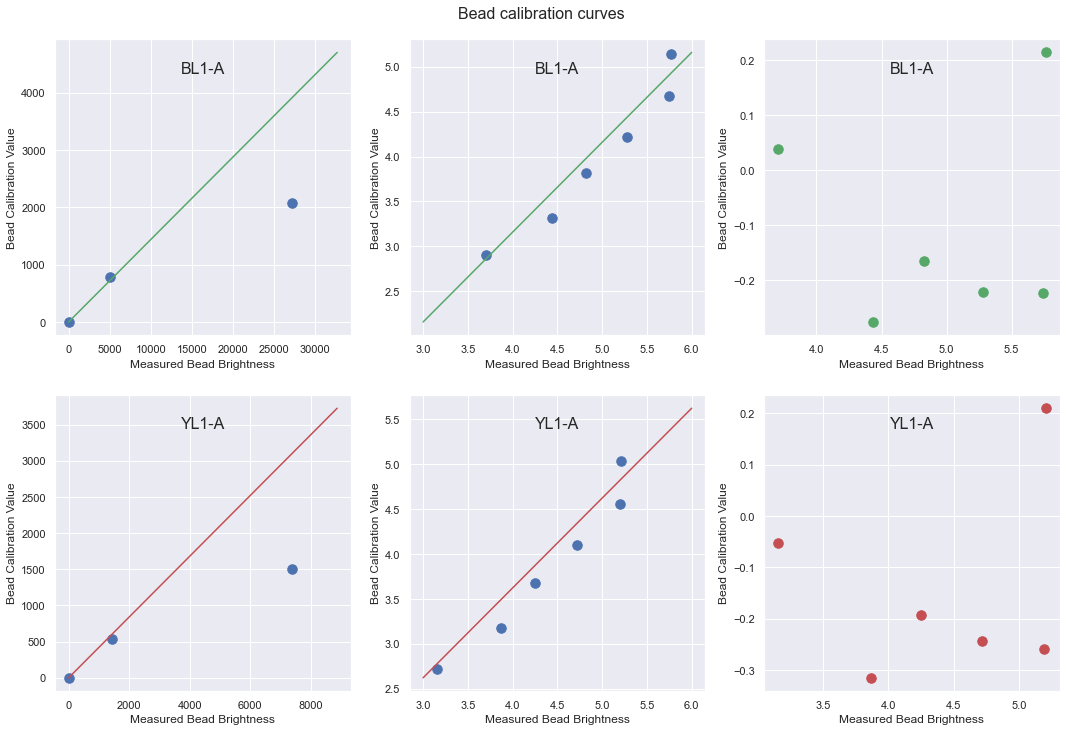

In [6]:
batch_p.fit_bead_data(data_directory=data_directory,
                      num_bead_populations=7,
                      bead_init=10,
                      singlet_init=5,
                      bead_population_init=10)

The diagnostics plots created by the fit_bead_data() include:<br>

Initial GMM fit results to find beads: The function starts with a GMM fit to the side-scatter vs. forward-scatter signals to find the beads. The plot on the left shows a 2D histogram of the data. The plot on the right shows a scatter plot of the data.
The function automatically chooses events in the most abundant cluster as the beads. In the diagnostic plot on the right, that cluster is plotted with purple points. <br>
The optional arguments ssc_min, ssc_max, fsc_min, and fsc_max can be used to ignore side-scatter and forward scatter data outside a specified range, if necessary. <br>

Second GMM fit results to find singlet bead events: The function then runs a second GMM fit, with the side-scatter height vs. width, to identify singlet bead events. <br>
The plot on the left shows a 2D histogram of the data. The plot on the right shows a scatter plot of the data.
The function automatically chooses events in the most abundant cluster as the singlet events. In the diagnostic plot on the right, that cluster is plotted with purple points. <br>

Final GMM fit results with fluorescence signals to find different beads: The final GMM fit uses the fluorescence signals from the BL1-A and YL1-A channels to identfy the different beads in the calibration set.<br>
The diagnostics plots show the cluster assignments with different colored points and shaded ellipses. The three 2D plots show the data at three different scales so that all the beads populations can be seen. Data that is ignored bassed on the outlier_quantile parameter (default value = 0.03) are plotted with red X's.<br>
The 1D histograms show the separate signals from the BL1-A and YL1-A channels, again with three plots each at different scales.

Bead calibration curves: The function fits the final GMM results and the bead calibration data (in MEF) to detirmine the calibration curve. <br>
The plots show the calibration curve for the BL1-A and YL1-A channels. For each channel, the left-most plot shows the results for lowest three beads on a linear scale, the middle plot shows the results for the non-zero beads on a logarithmic scale, and the right-most plot shows the fit residuals on a logarithmic scale. 

<br>
With 6 or more bead populations, it is difficult to get a good result with a random initialization, paricularly with outlier data. <br>
For example, in the result above, the GMM probably puts the two lowest intensity beads together in a single cluster and uses two clusters to cover one of the brighter beads. If not, try running the function again; random initilizations do sometimes work with the example data set.<br>

To overcome this problem, you can manually initialize the fit with means and covariances that are close to the correct values. These can be taken from a previous fit or estimated from a visual inspection of the plots (Final GMM fit results...).<br>

An example of a manual initilization is show below:

In [7]:
init_b = np.asarray([947, 4186, 10080, 27588, 67869, 193432, 571297])
init_y = np.asarray([420, 1167, 2721, 7342, 17831, 51894, 156897])
init_means = np.asarray([ [b, y] for (b, y) in zip(init_b, init_y) ])

init_covars = np.array([[1.0e+06, 5.1e+04],
                        [1.2e+06, 7.9e+04],
                        [2.1e+06, 1.7e+05],
                        [8.4e+06, 5.2e+05],
                        [3.3e+07, 9.4e+05],
                        [1.7e+08, 2.9e+06],
                        [7.4e+08, 1.0e+07]])

Main bead cluster mean: [253461.87955152 489258.10296524]


c:\users\djross\documents\python scripts\flowgatenist\flowgatenist\batch_process.py:3562: RuntimeWarning: invalid value encountered in log10
  return np.log10(a + b * (10**x))


(array([1.58106043e+01, 7.91539332e+02, 2.19173182e+03, 6.45723113e+03,
        1.61993184e+04, 4.66133592e+04, 1.39711798e+05]),
 array([-2.27323963e-01,  5.04532570e+02,  1.60651044e+03,  4.84523235e+03,
         1.21540274e+04,  3.60466232e+04,  1.10254093e+05]),
 array([  1083.86844349,   4230.50208422,   9910.18445562,  27212.57786218,
         66729.97417355, 190100.21979776, 567740.84186832]),
 array([   434.73119833,   1159.60511225,   2742.12983491,   7393.18285404,
         17889.17303719,  52200.77275146, 158768.38998312]),
 array([2.27377708e+06, 2.53095764e+06, 3.42803583e+06, 6.54095524e+06,
        1.81458202e+07, 8.61283466e+07, 4.78287657e+08]),
 array([   91320.30085024,    88964.10344567,   145050.50386005,
          321703.43536626,   702666.58627807,  2516401.55080752,
        11624796.93344979]),
 array([[2.27377708e+06, 9.13203009e+04],
        [2.53095764e+06, 8.89641034e+04],
        [3.42803583e+06, 1.45050504e+05],
        [6.54095524e+06, 3.21703435e+05],
  

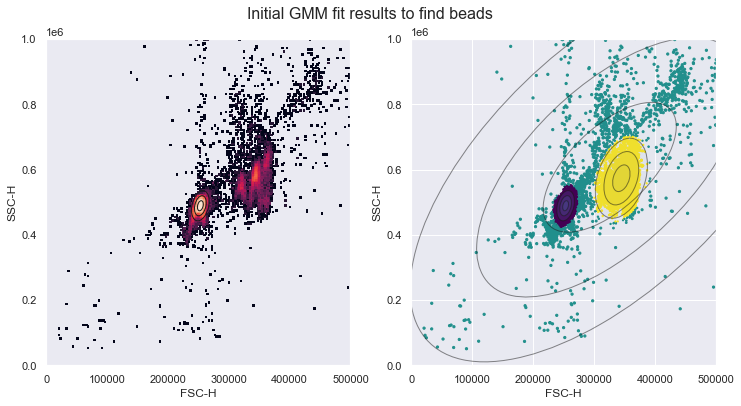

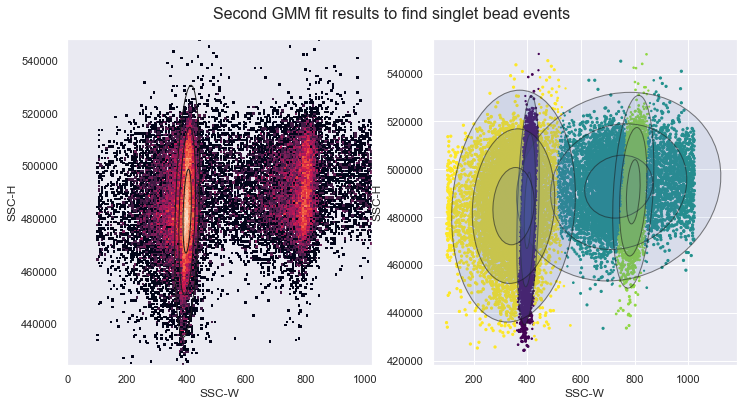

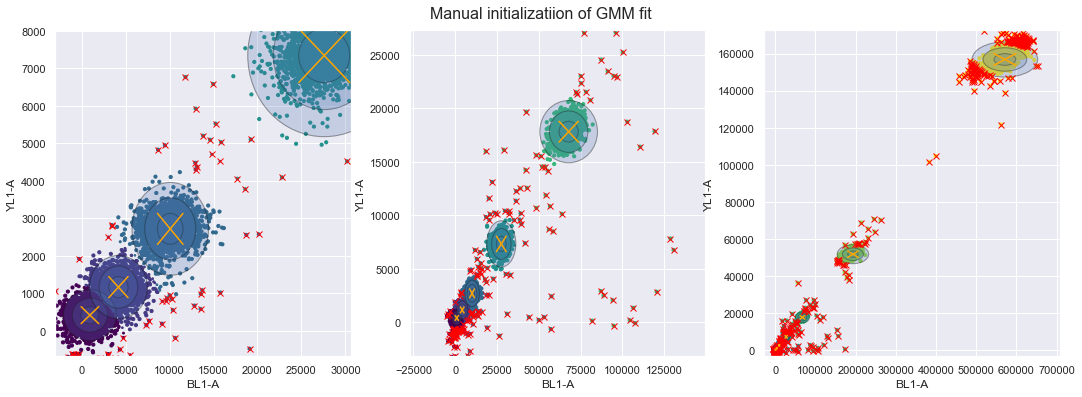

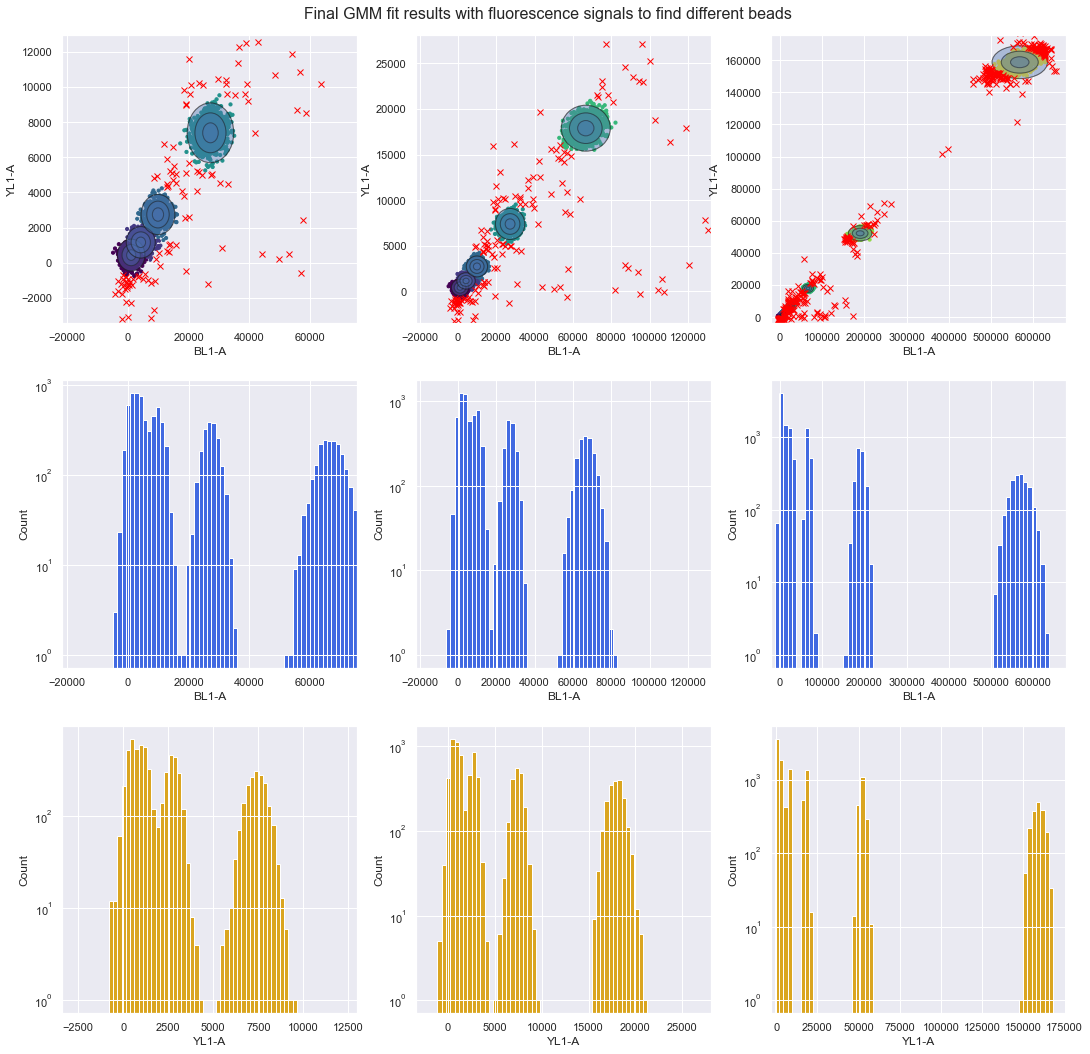

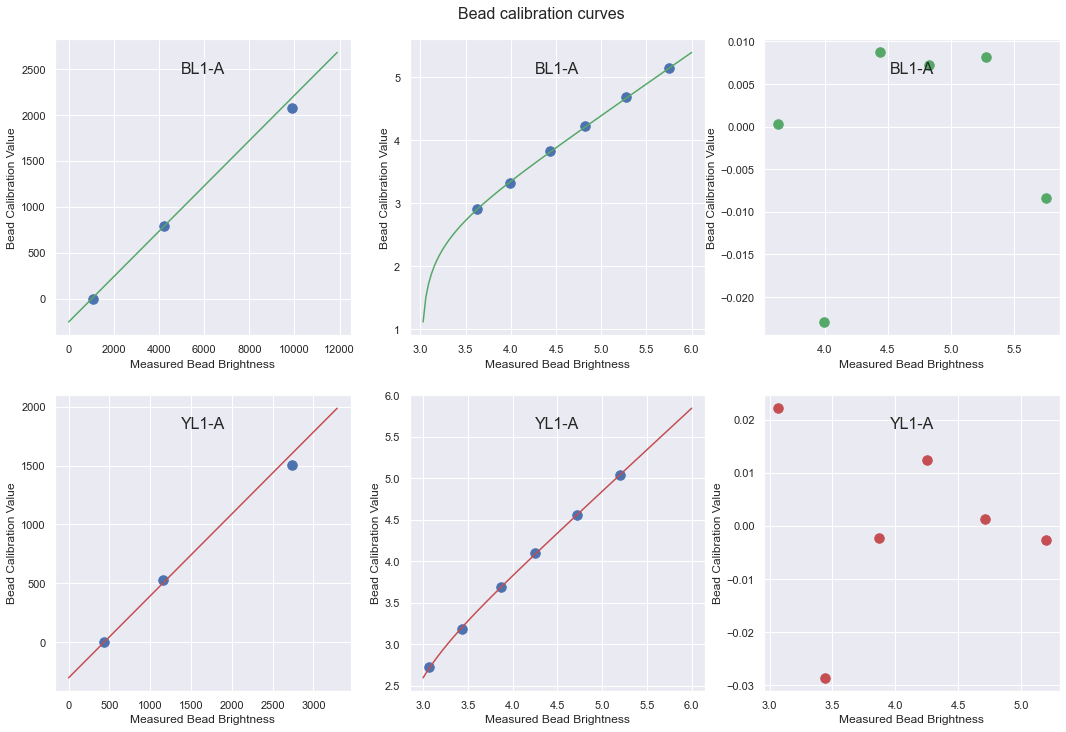

In [8]:
batch_p.fit_bead_data(data_directory=data_directory,
                      num_bead_populations=7,
                      bead_init=10,
                      singlet_init=5,
                      bead_population_init=100,
                      show_plots=True,
                      pop_init_means=init_means,
                      pop_init_cov=init_covars)

With manual initialization, the function includes an additional diagnotic plot: Manual initializatiion of GMM fit.<br>
In that plot, the values for pop_init_means and pop_init_cov are shown as large orange X's and ellipses. This plot can be used to adjust the manual initilization values, if necessary.<br> <br>


The final step in the bead calibration, is to apply the calibration curve to the fluorescece data for the cell samples.<br>
The batch_apply_bead_cal() function is used for this, with the data_directory and fl_channel arguments set.<br>
The function adds a new column to each of the FCSDataFrames with the corresponding MEF values.<br>

In the example below, the batch_apply_bead_cal() function is run twice, once for the 'BL1-A' channel and again for the YL1-A channel.

In [9]:
batch_p.batch_apply_bead_cal(data_directory=data_directory, fl_channel='BL1-A')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Cells_B1.fcs_pkl
Cells_B10.fcs_pkl
Cells_B11.fcs_pkl
Cells_B12.fcs_pkl
Cells_B2.fcs_pkl
Cells_B3.fcs_pkl
Cells_B4.fcs_pkl
Cells_B5.fcs_pkl
Cells_B6.fcs_pkl
Cells_B7.fcs_pkl
Cells_B8.fcs_pkl
Cells_B9.fcs_pkl
PBS blanks_A3.fcs_pkl
Beads_H12.fcs_pkl


In [10]:
batch_p.batch_apply_bead_cal(data_directory=data_directory, fl_channel='YL1-A')

Cells_B1.fcs_pkl
Cells_B10.fcs_pkl
Cells_B11.fcs_pkl
Cells_B12.fcs_pkl
Cells_B2.fcs_pkl
Cells_B3.fcs_pkl
Cells_B4.fcs_pkl
Cells_B5.fcs_pkl
Cells_B6.fcs_pkl
Cells_B7.fcs_pkl
Cells_B8.fcs_pkl
Cells_B9.fcs_pkl
PBS blanks_A3.fcs_pkl
Beads_H12.fcs_pkl


<br>
The next step in the flow cytometry data analysis depends on the goals for the cytometry measurements. An example of extracting dose-reposne curves from the calibrated cyteomtry data is shwon in the Jupyter notebook: "Notebook 3.Plot and save dose-response curves.ipynb".